# NeuroGraphNet

*A graph-based deep learning framework for EEG seizure detection, designed to improve accuracy and interpretability by leveraging Graph Neural Networks (GNNs) to capture spatial and temporal brain dynamics.*

<hr />

This notebook presents different approaches to EEG seizure detection using traditional machine learning and deep learning methods as well as a novel approaches using Graph Neural Networks (GNNs). The dataset used a subset of the TUSZ EEG Seizure dataset, which contains EEG recordings from patients with epilepsy.

**Authors**: Luca Di Bello, Guillaume André Bélissent, Abdessalem Ben Ali, Beatriz Izquierdo González

In [1]:
%load_ext autoreload
%autoreload 1
from pathlib import Path

import pandas as pd
import seaborn as sns
import torch
from src.utils.seeder import seed_everything

# set seaborn theme
sns.set_theme()

# create useful constants
RANDOM_SEED = 42
IS_SCITAS = True # set to True if running on SCITAS cluster
LOCAL_DATA_ROOT = Path("./data")
DATA_ROOT = Path("/home/ogut/data") if IS_SCITAS else LOCAL_DATA_ROOT
CHECKPOINT_ROOT = Path("./.checkpoints")
SUBMISSION_ROOT = Path("./.submissions")

# create directories if they do not exist
CHECKPOINT_ROOT.mkdir(parents=True, exist_ok=True)
SUBMISSION_ROOT.mkdir(parents=True, exist_ok=True)

# set dataset root
seed_everything(RANDOM_SEED)

# setup torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Run feature extraction script

In order to run all the models in this notebook, is necessary to run the feature extraction script first. This script extracts features from the EEG signals for both the training and test dataset, saving three files: `X_train.npy`, `y_train.npy`, and `X_test.npy`. The features extracted are the same used in the original paper, which are based on the EEG signals.

You can run the script by uncommenting and executing the cell below.

In [2]:
# import subprocess

# # execute feature extraction script
# process = None
# try:
#     process = subprocess.Popen(["python3", "scripts/feature_extractor.py"])
#     process.wait()
# except KeyboardInterrupt:
#     print("Process interrupted, terminating...")
#     if process:
#         process.terminate()
#         process.wait()
# except Exception as e:
#     print(f"Error occurred: {e}")
#     if process:
#         process.terminate()
#         process.wait()

## Define paths

The following paths are used to load the required data files and save the results of the models. Make sure to adjust them according to your local setup.

The current configuration assumes that the data files are located in a folder named `data` within the current working directory. 

**NOTE:** to simplify the process on SCITAS cluster, we provide a toggle `IS_SCITAS` to set the paths accordingly (_refer to first cell of the notebook_). If you are running this notebook on your local machine, you can set `IS_SCITAS = False` and adjust the paths as needed.

In [3]:
# spacial distance matrix between sensors
spatial_distance_file = LOCAL_DATA_ROOT / "distances_3d.csv"

# absdiff correlation matrix
absdiff_correlation_file = LOCAL_DATA_ROOT / "diff_corr_matrix.csv"

# training data
train_dir = DATA_ROOT / "train"
train_dir_metadata = train_dir / "segments.parquet"
train_dataset_absdiff_correlation_dir = LOCAL_DATA_ROOT / "graph_dataset_absdiff_correlation_train"
train_dataset_correlation_dir = LOCAL_DATA_ROOT / "graph_dataset_correlation_train"
train_dataset_spatial_dir = LOCAL_DATA_ROOT / "graph_dataset_spatial_train"
train_dataset_timeseries_feature_dir = str(LOCAL_DATA_ROOT / "timeseries_dataset_train_features")
train_dataset_timeseries_signal_dir = str(LOCAL_DATA_ROOT / "timeseries_dataset_train_signal")

# test data
test_dir = DATA_ROOT / "test"
test_dir_metadata = test_dir / "segments.parquet"
test_dataset_absdiff_correlation_dir = LOCAL_DATA_ROOT / "graph_dataset_absdiff_correlation_test"
test_dataset_correlation_dir = LOCAL_DATA_ROOT / "graph_dataset_correlation_test"
test_dataset_spatial_dir = LOCAL_DATA_ROOT / "graph_dataset_spatial_test"
test_dataset_timeseries_signal_dir = str(LOCAL_DATA_ROOT / "timeseries_dataset_test_signal")
test_dataset_timeseries_feature_dir = str(LOCAL_DATA_ROOT / "timeseries_dataset_test_features")

# additional features
extracted_features_dir = LOCAL_DATA_ROOT / "extracted_features"
embeddings_dir =  LOCAL_DATA_ROOT / "embeddings"

## Loading Train and Test Clips from the Dataset

To load patient clips from the dataset, we use the `load_clips` function. This function retrieves EEG signals and labels from the specified paths and returns them as NumPy arrays.

Different versions of Pandas may return either a MultiIndex or a single index, even when called with the same parameters. To address this inconsistency, we use the `ensure_eeg_multiindex` function to ensure that the resulting DataFrame has a MultiIndex structure. This is essential for subsequent processing steps.

If a MultiIndex is not present, it will be created using the following levels: `patient_id`, `clip_id`, and `channel`. This structure is crucial for organizing the dataset, as EEG signals are grouped by patient, clip, and channel. It also ensures compatibility with existing code that expects this format, such as the `EEGDataset` class from the [seizure-eeg](https://www.piwheels.org/project/seiz-eeg/) package.


In [4]:
from src.utils.index import ensure_eeg_multiindex 

# Load clips from datasets
clips_tr = pd.read_parquet(train_dir_metadata)
clips_tr = ensure_eeg_multiindex(clips_tr)
clips_tr['id'] = clips_tr.index.map(lambda x: '_'.join(str(i) for i in x))
assert clips_tr.id.nunique() == len(clips_tr), "There are duplicate IDs"
clips_tr = clips_tr[~clips_tr.label.isna()].reset_index()

# Load clips from datasets
clips_te = pd.read_parquet(test_dir_metadata)
clips_te = ensure_eeg_multiindex(clips_te)
clips_te['id'] = clips_te.index.map(lambda x: '_'.join(str(i) for i in x))
assert clips_te.id.nunique() == len(clips_te), "There are duplicate IDs"
clips_te = clips_te.reset_index()

# sort in order to maintain the same submission order
clips_te = clips_te.sort_values(by="id")

## Loading Datasets

This notebook explores various approaches to EEG seizure detection, requiring multiple dataset variants with distinct preprocessing strategies (e.g., raw EEG signals, extracted features, and diverse graph construction methods). The `GraphEEGDataset` class, a custom implementation of `torch.utils.data.Dataset`, is used to load these datasets based on specified parameters.

The `GraphEEGDataset` class is designed to support all preprocessing strategies, including graph-based approaches. It preprocesses EEG data on-the-fly, offering flexibility in data handling and model input preparation. Additionally, it includes a caching mechanism to store preprocessed data on disk. This mechanism ensures that subsequent calls with identical parameters load precomputed data, significantly reducing dataset loading time during repeated runs. This feature has been instrumental in accelerating development and experimentation within this notebook.

Specifically, we will load the following datasets:

A) **EEG signals**: 

- **Raw EEG**:

    - Feature-based

        - Raw EEG signals + signal time-filtering/rereferencing/normalization preprocessing

    - Graph-based

        - Raw EEG signals + spatial graph construction strategy + signal time-filtering/rereferencing/normalization preprocessing + graph-features

        - Raw EEG signals + correlation graph construction strategy (top-k policy with k=10) + signal time-filtering/rereferencing/normalization preprocessing + graph-features

        - Raw EEG signals + absolute difference correlation graph construction strategy (top-k policy with k=10) + signal time-filtering/rereferencing/normalization preprocessing + graph-features

- **Feature-based EEG**:

    - Extracted features + spatial graph construction strategy + signal time-filtering/rereferencing/normalization preprocessing

In [5]:
# Generael settings

# bandpass filter settings (signal time-filtering)
low_bandpass_frequency = 0.5
high_bandpass_frequency = 50

# additional settings
# NOTE: the training already fights class imbalance, so this is not used
oversampling_power = 1.0

### Raw-EEG signal datasets

#### A) Spatial graph construction strategy

In [6]:
%aimport
from src.data.dataset_graph import GraphEEGDataset

# load training dataset
dataset_spatial_tr = GraphEEGDataset(
    root=train_dataset_spatial_dir,
    clips=clips_tr,
    signal_folder=train_dir,
    extracted_features_dir=extracted_features_dir,
    use_selected_features=False,
    embeddings_dir=embeddings_dir,
    use_embeddings=False,
    edge_strategy="spatial",
    spatial_distance_file=(
        spatial_distance_file
    ),
    force_reprocess=False,
    bandpass_frequencies=(
        low_bandpass_frequency,
        high_bandpass_frequency,
    ),
    segment_length=3000,
    apply_filtering=True,
    apply_rereferencing=True,
    apply_normalization=True,
    sampling_rate=250,
    # extract graph features
    extract_graph_features=True,
    graph_feature_types=None # collect all graph features
)

# Check the length of the dataset
print(f"Length of dataset_spatial_tr: {len(dataset_spatial_tr)}")
print(f' Eliminated IDs: {dataset_spatial_tr.ids_to_eliminate}')
clips_spatial_tr = clips_tr[~clips_tr.index.isin(dataset_spatial_tr.ids_to_eliminate)]

Modules to reload:


Modules to skip:



/home/ldibello/venvs/neuro/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/ldibello/venvs/neuro/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c106detail14torchCheckFailEPKcS2_jRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
2025-06-09 22:53:56 - INFO - Initializing GraphEEGDataset...
2025-06-09 22:53:56 - INFO - Dataset parameters:
2025-06-09 22:53:56 - INFO -   - Root directory: data/graph_dataset_spatial_train
2025-06-09 22:53:56 - INFO -   - Edge strategy: spatial
2025-06-09 22:53:56 - INFO -   - Top-k neighbors: None
2025-06-09 22:53:56 - INFO -   - Correlation threshold: 0.7
2025-06-09 22:53:56 - INFO -   - Force reprocess: False
2025-06-09 22:53:56 - INFO -   - Bandpass frequencies: (0.5, 50)
2025-06-09 22:53:56 - INFO -   - Segment length: 3000
2025-06-0

Length of dataset_spatial_tr: 12993
 Eliminated IDs: []


In [7]:
# load training dataset
dataset_spatial_te = GraphEEGDataset(
    root=test_dataset_spatial_dir,
    clips=clips_te,
    signal_folder=test_dir,
    extracted_features_dir=extracted_features_dir,
    use_selected_features=False,
    embeddings_dir=embeddings_dir,
    use_embeddings=False,
    edge_strategy="spatial",
    spatial_distance_file=(
        spatial_distance_file
    ),
    force_reprocess=False,
    bandpass_frequencies=(
        low_bandpass_frequency,
        high_bandpass_frequency,
    ),
    segment_length=3000,
    apply_filtering=True,
    apply_rereferencing=True,
    apply_normalization=True,
    sampling_rate=250,
    # extract graph features
    extract_graph_features=True,
    graph_feature_types=None # collect all graph features
)

# Check the length of the dataset
print(f"Length of dataset_spatial_te: {len(dataset_spatial_te)}")
print(f' Eliminated IDs: {dataset_spatial_te.ids_to_eliminate}')
clips_spatial_te = clips_te[~clips_te.index.isin(dataset_spatial_te.ids_to_eliminate)]

2025-06-09 22:53:57 - INFO - Initializing GraphEEGDataset...
2025-06-09 22:53:57 - INFO - Dataset parameters:
2025-06-09 22:53:57 - INFO -   - Root directory: data/graph_dataset_spatial_test
2025-06-09 22:53:57 - INFO -   - Edge strategy: spatial
2025-06-09 22:53:57 - INFO -   - Top-k neighbors: None
2025-06-09 22:53:57 - INFO -   - Correlation threshold: 0.7
2025-06-09 22:53:57 - INFO -   - Force reprocess: False
2025-06-09 22:53:57 - INFO -   - Bandpass frequencies: (0.5, 50)
2025-06-09 22:53:57 - INFO -   - Segment length: 3000
2025-06-09 22:53:57 - INFO -   - Apply filtering: True
2025-06-09 22:53:57 - INFO -   - Apply rereferencing: True
2025-06-09 22:53:57 - INFO -   - Apply normalization: True
2025-06-09 22:53:57 - INFO -   - Sampling rate: 250
2025-06-09 22:53:57 - INFO -   - Test mode: False
2025-06-09 22:53:57 - INFO -   - Extract graph features: True
2025-06-09 22:53:57 - INFO -   - Diff Corr Matrix Path: None
2025-06-09 22:53:57 - INFO - Initializing graph feature extractor

Length of dataset_spatial_te: 0
 Eliminated IDs: []


#### B) Correlation graph construction strategy

In [8]:
# general settings
top_k = 5

In [9]:
%aimport
from src.data.dataset_graph import GraphEEGDataset

# load training dataset
dataset_corr_tr = GraphEEGDataset(
    root=train_dataset_correlation_dir,
    clips=clips_tr,
    signal_folder=train_dir,
    extracted_features_dir=extracted_features_dir,
    use_selected_features=False,
    embeddings_dir=embeddings_dir,
    use_embeddings=False,
    edge_strategy="correlation",
    spatial_distance_file=None,
    top_k=top_k,
    force_reprocess=False,
    bandpass_frequencies=(
        low_bandpass_frequency,
        high_bandpass_frequency,
    ),
    segment_length=3000,
    apply_filtering=True,
    apply_rereferencing=True,
    apply_normalization=True,
    sampling_rate=250,
    # extract graph features
    extract_graph_features=True,
    graph_feature_types=None # collect all graph features
)

# Check the length of the dataset
print(f"Length of dataset_corr_tr: {len(dataset_corr_tr)}")
print(f' Eliminated IDs: {dataset_corr_tr.ids_to_eliminate}')
clips_corr_tr = clips_tr[~clips_tr.index.isin(dataset_corr_tr.ids_to_eliminate)]

2025-06-09 22:53:57 - INFO - Initializing GraphEEGDataset...
2025-06-09 22:53:57 - INFO - Dataset parameters:
2025-06-09 22:53:57 - INFO -   - Root directory: data/graph_dataset_correlation_train
2025-06-09 22:53:57 - INFO -   - Edge strategy: correlation
2025-06-09 22:53:57 - INFO -   - Top-k neighbors: 5
2025-06-09 22:53:57 - INFO -   - Correlation threshold: 0.7
2025-06-09 22:53:57 - INFO -   - Force reprocess: False
2025-06-09 22:53:57 - INFO -   - Bandpass frequencies: (0.5, 50)
2025-06-09 22:53:57 - INFO -   - Segment length: 3000
2025-06-09 22:53:57 - INFO -   - Apply filtering: True
2025-06-09 22:53:57 - INFO -   - Apply rereferencing: True
2025-06-09 22:53:57 - INFO -   - Apply normalization: True
2025-06-09 22:53:57 - INFO -   - Sampling rate: 250
2025-06-09 22:53:57 - INFO -   - Test mode: False
2025-06-09 22:53:57 - INFO -   - Extract graph features: True
2025-06-09 22:53:57 - INFO -   - Diff Corr Matrix Path: None
2025-06-09 22:53:57 - INFO - Initializing graph feature ext

Modules to reload:


Modules to skip:

Length of dataset_corr_tr: 12986
 Eliminated IDs: []


In [10]:
%aimport
from src.data.dataset_graph import GraphEEGDataset

# load training dataset
dataset_corr_te = GraphEEGDataset(
    root=test_dataset_correlation_dir,
    clips=clips_te,
    signal_folder=test_dir,
    extracted_features_dir=extracted_features_dir,
    use_selected_features=False,
    embeddings_dir=embeddings_dir,
    use_embeddings=False,
    edge_strategy="spatial",
    spatial_distance_file=(
        spatial_distance_file
    ),
    top_k=None,
    force_reprocess=False,
    bandpass_frequencies=(
        low_bandpass_frequency,
        high_bandpass_frequency,
    ),
    segment_length=3000,
    apply_filtering=True,
    apply_rereferencing=True,
    apply_normalization=True,
    sampling_rate=250,
    # extract graph features
    is_test=True, # NOTE: needed to let the dataset know that is okay to now have labels!
    extract_graph_features=True,
    graph_feature_types=None # collect all graph features
)

# Check the length of the dataset
print(f"Length of dataset_corr_te: {len(dataset_corr_te)}")
print(f' Eliminated IDs:{dataset_corr_te.ids_to_eliminate}')
clips_spatial_te = clips_te[~clips_te.index.isin(dataset_corr_te.ids_to_eliminate)].reset_index(drop=True)

2025-06-09 22:53:57 - INFO - Initializing GraphEEGDataset...
2025-06-09 22:53:57 - INFO - Dataset parameters:
2025-06-09 22:53:57 - INFO -   - Root directory: data/graph_dataset_correlation_test
2025-06-09 22:53:57 - INFO -   - Edge strategy: spatial
2025-06-09 22:53:57 - INFO -   - Top-k neighbors: None
2025-06-09 22:53:57 - INFO -   - Correlation threshold: 0.7
2025-06-09 22:53:57 - INFO -   - Force reprocess: False
2025-06-09 22:53:57 - INFO -   - Bandpass frequencies: (0.5, 50)
2025-06-09 22:53:57 - INFO -   - Segment length: 3000
2025-06-09 22:53:57 - INFO -   - Apply filtering: True
2025-06-09 22:53:57 - INFO -   - Apply rereferencing: True
2025-06-09 22:53:57 - INFO -   - Apply normalization: True
2025-06-09 22:53:57 - INFO -   - Sampling rate: 250
2025-06-09 22:53:57 - INFO -   - Test mode: True
2025-06-09 22:53:57 - INFO -   - Extract graph features: True
2025-06-09 22:53:57 - INFO -   - Diff Corr Matrix Path: None


Modules to reload:


Modules to skip:



2025-06-09 22:53:57 - INFO - Initializing graph feature extractor...
2025-06-09 22:53:57,416 - src.utils.graph_features - INFO - GraphFeatureExtractor initialized with features: ['degree', 'clustering', 'centrality', 'connectivity', 'path_length', 'efficiency', 'assortativity', 'modularity', 'laplacian_spectrum', 'k_core']
2025-06-09 22:53:57 - INFO - GraphFeatureExtractor initialized with features: ['degree', 'clustering', 'centrality', 'connectivity', 'path_length', 'efficiency', 'assortativity', 'modularity', 'laplacian_spectrum', 'k_core']
2025-06-09 22:53:57 - INFO - Graph feature types: ['degree', 'clustering', 'centrality', 'connectivity', 'path_length', 'efficiency', 'assortativity', 'modularity', 'laplacian_spectrum', 'k_core']
2025-06-09 22:53:57 - INFO - Number of EEG channels: 19
2025-06-09 22:53:57 - INFO - Setting up signal filters...
2025-06-09 22:53:57 - INFO - Loading spatial distances from data/distances_3d.csv
2025-06-09 22:53:57 - INFO - Loading spatial distances fr

Length of dataset_corr_te: 3614
 Eliminated IDs:[]


#### C) Absolute difference correlation graph construction strategy

In [11]:
# general settings
top_k = 8

In [12]:
%aimport
from src.data.dataset_graph import GraphEEGDataset

# load training dataset
dataset_absdiff_corr_tr = GraphEEGDataset(
    root=train_dataset_absdiff_correlation_dir,
    clips=clips_tr,
    signal_folder=train_dir,
    extracted_features_dir=extracted_features_dir,
    use_selected_features=False,
    embeddings_dir=embeddings_dir,
    use_embeddings=False,
    edge_strategy="relevance_diff_correlation",
    spatial_distance_file=None,
    top_k=top_k,
    force_reprocess=False,
    bandpass_frequencies=(
        low_bandpass_frequency,
        high_bandpass_frequency,
    ),
    segment_length=3000,
    apply_filtering=True,
    apply_rereferencing=True,
    apply_normalization=True,
    sampling_rate=250,
    # extract graph features
    extract_graph_features=True,
    graph_feature_types=None, # collect all graph features
    # settings for absolute difference correlation
    diff_corr_matrix_path=absdiff_correlation_file,
)

# Check the length of the dataset
print(f"Length of dataset_absdiff_corr_tr: {len(dataset_absdiff_corr_tr)}")
print(f' Eliminated IDs: {dataset_absdiff_corr_tr.ids_to_eliminate}')
clips_absdiff_corr_tr = clips_tr[~clips_tr.index.isin(dataset_absdiff_corr_tr.ids_to_eliminate)]

2025-06-09 22:53:57 - INFO - Initializing GraphEEGDataset...
2025-06-09 22:53:57 - INFO - Dataset parameters:
2025-06-09 22:53:57 - INFO -   - Root directory: data/graph_dataset_absdiff_correlation_train
2025-06-09 22:53:57 - INFO -   - Edge strategy: relevance_diff_correlation
2025-06-09 22:53:57 - INFO -   - Top-k neighbors: 8
2025-06-09 22:53:57 - INFO -   - Correlation threshold: 0.7
2025-06-09 22:53:57 - INFO -   - Force reprocess: False
2025-06-09 22:53:57 - INFO -   - Bandpass frequencies: (0.5, 50)
2025-06-09 22:53:57 - INFO -   - Segment length: 3000
2025-06-09 22:53:57 - INFO -   - Apply filtering: True
2025-06-09 22:53:57 - INFO -   - Apply rereferencing: True
2025-06-09 22:53:57 - INFO -   - Apply normalization: True
2025-06-09 22:53:57 - INFO -   - Sampling rate: 250
2025-06-09 22:53:57 - INFO -   - Test mode: False
2025-06-09 22:53:57 - INFO -   - Extract graph features: True
2025-06-09 22:53:57 - INFO -   - Diff Corr Matrix Path: data/diff_corr_matrix.csv
2025-06-09 22:5

Modules to reload:


Modules to skip:

Length of dataset_absdiff_corr_tr: 4646
 Eliminated IDs: []


In [13]:
%aimport
from src.data.dataset_graph import GraphEEGDataset

# load test dataset
dataset_absdiff_corr_te = GraphEEGDataset(
    root=test_dataset_absdiff_correlation_dir,
    clips=clips_te,
    signal_folder=test_dir,
    extracted_features_dir=extracted_features_dir,
    use_selected_features=False,
    embeddings_dir=embeddings_dir,
    use_embeddings=False,
    edge_strategy="relevance_diff_correlation",
    spatial_distance_file=None,
    top_k=top_k,
    force_reprocess=False,
    bandpass_frequencies=(
        low_bandpass_frequency,
        high_bandpass_frequency,
    ),
    segment_length=3000,
    apply_filtering=True,
    apply_rereferencing=True,
    apply_normalization=True,
    sampling_rate=250,
    # extract graph features
    extract_graph_features=True,
    graph_feature_types=None, # collect all graph features
    # settings for absolute difference correlation
    diff_corr_matrix_path=absdiff_correlation_file,
)

# Check the length of the dataset
print(f"Length of dataset_absdiff_corr_te: {len(dataset_absdiff_corr_te)}")
print(f' Eliminated IDs: {dataset_absdiff_corr_te.ids_to_eliminate}')
clips_absdiff_corr_te = clips_te[~clips_te.index.isin(dataset_absdiff_corr_te.ids_to_eliminate)]

2025-06-09 22:53:57 - INFO - Initializing GraphEEGDataset...
2025-06-09 22:53:57 - INFO - Dataset parameters:
2025-06-09 22:53:57 - INFO -   - Root directory: data/graph_dataset_absdiff_correlation_test
2025-06-09 22:53:57 - INFO -   - Edge strategy: relevance_diff_correlation
2025-06-09 22:53:57 - INFO -   - Top-k neighbors: 8
2025-06-09 22:53:57 - INFO -   - Correlation threshold: 0.7
2025-06-09 22:53:57 - INFO -   - Force reprocess: False
2025-06-09 22:53:57 - INFO -   - Bandpass frequencies: (0.5, 50)
2025-06-09 22:53:57 - INFO -   - Segment length: 3000
2025-06-09 22:53:57 - INFO -   - Apply filtering: True
2025-06-09 22:53:57 - INFO -   - Apply rereferencing: True
2025-06-09 22:53:57 - INFO -   - Apply normalization: True
2025-06-09 22:53:57 - INFO -   - Sampling rate: 250
2025-06-09 22:53:57 - INFO -   - Test mode: False
2025-06-09 22:53:57 - INFO -   - Extract graph features: True
2025-06-09 22:53:57 - INFO -   - Diff Corr Matrix Path: data/diff_corr_matrix.csv
2025-06-09 22:53

Modules to reload:


Modules to skip:

Length of dataset_absdiff_corr_te: 0
 Eliminated IDs: []


### Timeseries datasets

In [14]:
%aimport
from src.utils.timeseries_eeg_dataset import TimeseriesEEGDataset

dataset_timeseries_signal_tr = TimeseriesEEGDataset(
    root=str(train_dataset_timeseries_signal_dir),
    signal_folder=str(train_dir),
    clips_df=clips_tr,
    bandpass_frequencies=(
        low_bandpass_frequency,
        high_bandpass_frequency,
    ),
    force_reprocess=False,
    apply_filtering=True,
    apply_rereferencing=True,
    apply_normalization=True,
    sampling_rate=250,
    mode='signal', # Use raw EEG signal data
)
dataset_timeseries_signal_te = TimeseriesEEGDataset(
    root=str(test_dataset_timeseries_signal_dir),
    signal_folder=str(train_dir),
    clips_df=clips_te,
    bandpass_frequencies=(
        low_bandpass_frequency,
        high_bandpass_frequency,
    ),
    apply_filtering=True,
    apply_rereferencing=True,
    apply_normalization=True,
    sampling_rate=250,
    mode='signal', # Use raw EEG signal data
)

Modules to reload:


Modules to skip:

🚀 Initializing TimeseriesEEGDataset in SIGNAL mode.
   - Sampling rate: 250 Hz
   - Derived segment length: 3000 timesteps.
   - Segment length: 3000 timesteps.
   ✅ Using existing cached data from data/timeseries_dataset_train_signal/processed
🏁 TimeseriesEEGDataset initialization complete. Loaded 12993 samples.
🚀 Initializing TimeseriesEEGDataset in SIGNAL mode.
   - Sampling rate: 250 Hz
   - Derived segment length: 3000 timesteps.
   - Segment length: 3000 timesteps.
   ⚠️ Info: Column 'label' not found in clips_df. Processing without labels (e.g., test set).
   ✅ Using existing cached data from data/timeseries_dataset_test_signal/processed
🏁 TimeseriesEEGDataset initialization complete. Loaded 3614 samples.


In [15]:
%aimport
from src.utils.timeseries_eeg_dataset import TimeseriesEEGDataset

dataset_timeseries_feature_tr = TimeseriesEEGDataset(
    root=str(train_dataset_timeseries_feature_dir),
    signal_folder=str(train_dir),
    clips_df=clips_tr,
    bandpass_frequencies=(
        low_bandpass_frequency,
        high_bandpass_frequency,
    ),
    apply_filtering=True,
    apply_rereferencing=True,
    apply_normalization=True,
    sampling_rate=250,
    mode='feature',
    feature_file_path=str(extracted_features_dir / "X_train.npy"),
)
dataset_timeseries_feature_te = TimeseriesEEGDataset(
    root=str(test_dataset_timeseries_feature_dir),
    signal_folder=str(train_dir),
    clips_df=clips_te,
    bandpass_frequencies=(
        low_bandpass_frequency,
        high_bandpass_frequency,
    ),
    apply_filtering=True,
    apply_rereferencing=True,
    apply_normalization=True,
    sampling_rate=250,
    mode='feature',
    feature_file_path=str(extracted_features_dir / "X_test.npy"),
)

Modules to reload:


Modules to skip:

🚀 Initializing TimeseriesEEGDataset in FEATURE mode.
   ✅ Using existing cached data from data/timeseries_dataset_train_features/processed
🏁 TimeseriesEEGDataset initialization complete. Loaded 12993 samples.
🚀 Initializing TimeseriesEEGDataset in FEATURE mode.
   ⚠️ Info: Column 'label' not found in clips_df. Processing without labels (e.g., test set).
   ✅ Using existing cached data from data/timeseries_dataset_test_features/processed
🏁 TimeseriesEEGDataset initialization complete. Loaded 3614 samples.


In [16]:
%aimport
from src.utils.lazy import LazyDataLoaderManager, TrainingContext

datasets = {
    # timeseries datasets
    "signal": {
        "dataset_tr": dataset_timeseries_signal_tr,
        "dataset_te": dataset_timeseries_signal_te,
        "clips_tr": clips_tr
    },
    "feature": {
        "dataset_tr": dataset_timeseries_feature_tr,
        "dataset_te": dataset_timeseries_feature_te,
        "clips_tr": clips_tr
    },
    # graph datasets
    "spatial": {
        "dataset_tr": dataset_spatial_tr,
        "dataset_te": dataset_spatial_te,
        "clips_tr": clips_spatial_tr,
    },
    "correlation": {
        "dataset_tr": dataset_corr_tr,
        "dataset_te": dataset_corr_te,
        "clips_tr": clips_corr_tr,
    },
    "absolute_difference": {
        "dataset_tr": dataset_absdiff_corr_tr,
        "dataset_te": dataset_absdiff_corr_te,
        "clips_tr": clips_absdiff_corr_tr,
    }
}

# create loaders for both datasets
loader_manager = LazyDataLoaderManager(
    datasets,
    oversampling_power=oversampling_power,
    batch_size=64
)

# create train context
training_context = TrainingContext(loader_manager)

Modules to reload:


Modules to skip:

✅ TrainingContext initialized. Use .switch_to('dataset_type') to begin.


## Dataset Selection and Training Configuration

This section allows you to select which dataset type to use for training by modifying the `DATASET_TYPE` variable in the next cell. The notebook supports multiple dataset types, each with different preprocessing strategies and model architectures.

### Available Dataset Types

#### Graph-Based Datasets (for GNN models):
- **`'spatial'`** - Uses spatial distance-based graph connections between EEG electrodes
- **`'correlation'`** - Uses correlation-based graph connections (top-k=5)
- **`'absdiff_correlation'`** - Uses absolute difference correlation graph connections (top-k=8)

#### Timeseries Datasets (for traditional deep learning models):
- **`'signal'`** - Raw EEG signal data with temporal processing
- **`'features'`** - Pre-extracted feature representations

### Data Loaders Structure

All datasets are automatically split into train/validation/test sets with the following configuration:
- **Train/Validation ratio**: 80/20
- **Random seed**: 42 (for reproducibility)  
- **Class balancing**: WeightedRandomSampler with oversampling power = 1.0
- **Batch size**: 64

The data loaders are organized in dictionaries for easy access:
- `graph_loaders` - Contains loaders for all graph-based datasets
- `timeseries_loaders` - Contains loaders for all timeseries datasets

### Usage Instructions

1. Set the `DATASET_TYPE` variable to your desired dataset type
2. The notebook will automatically configure the appropriate data loaders
3. Use the selected `train_loader`, `val_loader`, and `te_loader` for model training
4. Choose the corresponding model architecture (GNN for graph datasets, traditional models for timeseries datasets)

In [17]:
%aimport
import torch.optim as optim
import torch.nn as nn
from src.layers.hybrid.cnn_bilstm_gcn import EEGCNNBiLSTMGCN
from src.utils.train import train_model
from src.utils.plot import plot_training_loss

config = {
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "patience": 10,
    "epochs": 100,
}

Modules to reload:


Modules to skip:



ModuleNotFoundError: No module named 'utils'

## Training and Evaluation - Timeseries Models

In this section, we will train and evaluate traditional deep learning models on the selected timeseries dataset. The models will be trained using the `train_loader` and evaluated on the `val_loader` and `te_loader` (the latter being used for final evaluation after training. Labels are not available for the test set, so we will not compute metrics on it).

In [ ]:
%aimport src.utils.train
from src.utils.train import train_k_fold

def wrap_traditional_train(model, save_path):
    global train_context
    if 'train_context' not in globals():
        raise ValueError("Timeseries training context is not initialized. Please initialize it before calling this function.")
    if not isinstance(train_context, TrainingContext):
        raise ValueError("train_context must be an instance of TrainingContext.")
    model = model.to(device)

    # if multiple GPUs are available, use DataParallel
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for training")
        model = nn.DataParallel(model)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=1e-4, weight_decay=0.01, betas=(0.9, 0.999))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5)
    loss = nn.BCEWithLogitsLoss()  # Not weighted as we use a balanced sampler!

    # train model
    train_history, val_history = train_model(
        wandb_config=None,
        model=model,
        train_loader=train_context.train_loader,
        val_loader=train_context.val_loader,
        criterion=loss,
        scheduler=scheduler,
        optimizer=optimizer,
        device=device,
        num_epochs=config["epochs"],
        patience=config["patience"],
        save_path=save_path,
        use_gnn=False,
        # hidden attribute
        try_load_checkpoint=True,
        # FIXME: remove this before submission
        log_wandb=False,
    )
    plot_training_loss(train_history["loss"], val_history["loss"])

def traditional_k_fold_train(model_class, model_parameters, save_path, batch_size=64):
    global train_context

    if 'train_context' not in globals():
        raise ValueError("Timeseries training context is not initialized. Please initialize it before calling this function.")
    if not isinstance(train_context, TrainingContext):
        raise ValueError("train_context must be an instance of TrainingContext.")

    import torch.nn as nn # force import to avoid bug

    # train model
    aggregated_train_history, aggregated_val_history, fold_results = train_k_fold(
        # dataset to use
        dataset=datasets[train_context.dataset_type]["dataset_tr"],
        labels=train_context.clips["label"].values,
        # train models
        model_class=model_class,
        model_kwargs=model_parameters,
        # optimizer
        criterion=nn.BCEWithLogitsLoss(),
        optimizer_class=torch.optim.AdamW,
        optimizer_kwargs={
            "lr": config["learning_rate"],
            "weight_decay": config["weight_decay"],
            "betas": (0.9, 0.999)
        },
        # scheduler
        scheduler_class=optim.lr_scheduler.ReduceLROnPlateau,
        scheduler_kwargs={
            "mode": 'min',
            "factor": 0.5,
            "patience": 5
        },
        batch_size=batch_size,
        wandb_config=None,
        device=device,
        num_epochs=config["epochs"],
        patience=config["patience"],
        use_gnn=False,
        # hidden attribute
        log_wandb=False,
        save_dir=save_path,
    )
    plot_training_loss(aggregated_train_history["loss"], aggregated_val_history["loss"])

#### LSTM (signal-based model)

The LSTM model is a recurrent neural network (RNN) architecture designed to handle sequential data, making it suitable for time-series analysis like EEG signals. It captures temporal dependencies in the data, allowing it to learn patterns over time.

2025-06-09 20:21:28 - INFO - Starting 5-fold cross-validation
2025-06-09 20:21:28 - INFO - Dataset size: 12993
2025-06-09 20:21:28 - INFO - Stratified: True
2025-06-09 20:21:28 - INFO - Batch size: 512
2025-06-09 20:21:28 - INFO - Using stratified k-fold with label distribution
2025-06-09 20:21:28 - INFO - Created 5 folds
2025-06-09 20:21:28 - INFO - Folds: [(array([    0,     2,     3, ..., 12990, 12991, 12992]), array([    1,     5,     6, ..., 12979, 12983, 12985])), (array([    0,     1,     2, ..., 12988, 12989, 12990]), array([    3,    19,    27, ..., 12977, 12991, 12992])), (array([    0,     1,     3, ..., 12987, 12991, 12992]), array([    2,     7,    17, ..., 12988, 12989, 12990])), (array([    0,     1,     2, ..., 12990, 12991, 12992]), array([    4,     9,    12, ..., 12975, 12978, 12987])), (array([    1,     2,     3, ..., 12990, 12991, 12992]), array([    0,    10,    16, ..., 12976, 12981, 12986]))]
2025-06-09 20:21:28 - INFO - 
2025-06-09 20:21:28 - INFO - FOLD 1/5
2


🌐 Switching context to 'SIGNAL' dataset...
🚀 Context ready for 'signal'.
   Train batches: 162, Val batches: 41
   Type: signal
   Total Train Samples: 12993
   Channels: 19
   Sequence Length: 3000
 🗑️ Overwrite enabled: Removed existing checkpoint at .checkpoints/timeseries_signal_lstm_k_fold.pt/fold_1_best_model.pth


Epochs:   1%|▊                                                                                  | 1/100 [00:00<?, ?it/s]2025-06-09 20:21:28 - INFO - 
Epoch 1/100 - Training phase
2025-06-09 20:21:29 - INFO - Processing batch 1/21
2025-06-09 20:21:29 - INFO - Batch 1/21 - Loss: 0.7109 - Avg batch time: 0.28s
2025-06-09 20:21:44 - INFO - Processing batch 11/21
2025-06-09 20:21:44 - INFO - Batch 11/21 - Loss: 0.7029 - Avg batch time: 0.21s
2025-06-09 20:21:54 - INFO - Processing batch 21/21
2025-06-09 20:21:54 - INFO - Batch 21/21 - Loss: 0.6942 - Avg batch time: 0.19s
2025-06-09 20:21:54 - INFO - 
Epoch 1 training completed in 26.03s
2025-06-09 20:21:54 - INFO - Average training loss: 0.7021
Epochs:   2%| | 2/100 [00:31<50:52, 31.15s/it, train_loss=0.7021, val_loss=0.6924, best_val_f1=0.1871, lr=1.00e-04, bad_2025-06-09 20:21:59 - INFO - 
Epoch 2/100 - Training phase
2025-06-09 20:22:00 - INFO - Processing batch 1/21
2025-06-09 20:22:00 - INFO - Batch 1/21 - Loss: 0.6913 - Avg batch time

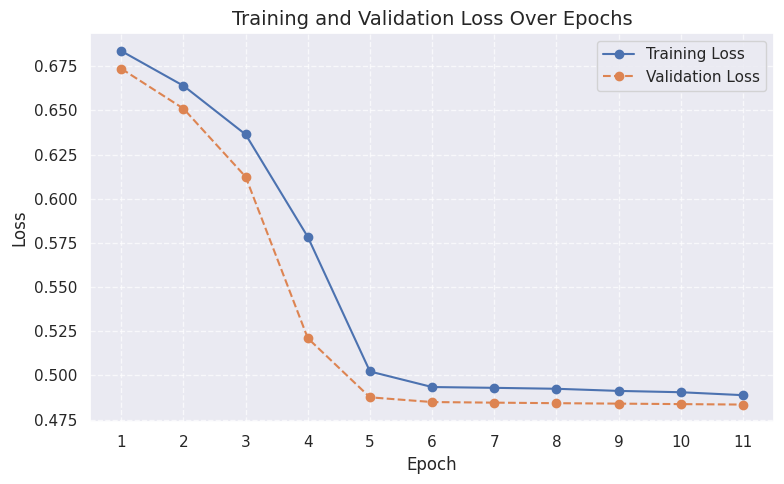

In [ ]:
%aimport src.layers.temporal.lstm
from src.layers.temporal.lstm import EEGLSTMClassifier

# create loader manager
train_context = training_context.switch_to('signal')

# build model with current parameters
SAVE_PATH = CHECKPOINT_ROOT / "timeseries_signal_lstm_baseline.pt"

traditional_k_fold_train(
    model_class=EEGLSTMClassifier,
    model_parameters={
        "input_dim": 19,
        "hidden_dim": 64,
        "num_layers": 4,
        "dropout": 0.3,
        "bidirectional": False,
    },
    save_path=CHECKPOINT_ROOT / "timeseries_signal_lstm_k_fold.pt",
    batch_size=512 # higher batch size for faster training
)

#### BiLSTM (signal-based model)

The BiLSTM (Bidirectional Long Short-Term Memory) model extends the LSTM by processing the input sequence in both forward and backward directions. This bidirectional approach allows the model to capture context from both past and future time steps, enhancing its ability to understand complex temporal relationships in the data.


In [ ]:
%aimport src.layers.temporal.lstm
from src.layers.temporal.lstm import EEGLSTMClassifier

# create loader manager
train_context = training_context.switch_to('signal')
traditional_k_fold_train(
    model_class=EEGLSTMClassifier,
    model_parameters={
        "input_dim": 19,
        "hidden_dim": 64,
        "num_layers": 4,
        "dropout": 0.3,
        "bidirectional": True, # use bidirectional LSTM
    },
    save_path=CHECKPOINT_ROOT / "timeseries_signal_bilstm_k_fold.pt",
    batch_size=512 # higher batch size for faster training
)

#### MLP (feature-based model)

The MLP (Multi-Layer Perceptron) is a feedforward neural network architecture consisting of multiple layers of neurons. It is designed to learn complex mappings from input features to output labels, making it suitable for tasks like EEG seizure detection when using pre-extracted features.

In [ ]:
%aimport src.layers.mlp
from src.layers.mlp import EEGMLPClassifier

train_context = training_context.switch_to('feature')
traditional_k_fold_train(
    model_class=EEGMLPClassifier,
    model_parameters={
        "input_dim": 228, # extracted features dimension
        "hidden_dims": [1024, 512, 256],
        "output_dim": 1,
        "dropout_prob": 0.3,
        "use_batch_norm": True,
        "use_residual": False,
        "activation": "relu"
    },
    save_path=CHECKPOINT_ROOT / "timeseries_feature_mlp_k_fold.pt",
    batch_size=512 # higher batch size for faster training
)


#### MLP (signal-based model, flattened EEG signals)

The same MLP architecture as above, but trained on raw EEG signals instead of pre-extracted features to evaluate the performance of the model on raw data.


In [ ]:
%aimport src.layers.mlp
from src.layers.mlp import EEGMLPClassifier

# switch to signal dataset
train_context = training_context.switch_to('signal')

# build model with current parameters
SAVE_PATH = CHECKPOINT_ROOT / "timeseries_signal_mlp.pt"
model = EEGMLPClassifier(
    # 19 channels * 3000 time steps = 57,000
    input_channels=19,
    input_time_steps=3000,
    hidden_dims=[4096, 2048, 1024, 512, 256],
    output_dim=1,
    dropout_prob=0.3,
    use_batch_norm=True,
    use_residual=False,
    activation="leaky_relu"
)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for this combination.")
    model = nn.DataParallel(model)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()  # Assuming this remains constant
optimizer = optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
wrap_traditional_train(model, save_path=SAVE_PATH)

#### CNN-MLP (signal-based model)

We have proven that the MLP model alone is not sufficient to capture the temporal dependencies in the EEG signals. Therefore, we will use a CNN-MLP model that combines convolutional layers to extract spatial features from the EEG signals and MLP layers to learn the mapping from these features to the output labels.


In [ ]:
%aimport src.layers.cnn.cnn
from src.layers.cnn.cnn import EEGCNNClassifier

train_context = training_context.switch_to('signal')
# build model with current parameters
SAVE_PATH = CHECKPOINT_ROOT / "timeseries_signal_cnn_mlp.pt"
model = EEGCNNClassifier(
    input_channels=19,
    cnn_out_dim=128,
    mlp_hidden_dims=[256, 128],
    output_dim=1,
    cnn_dropout_prob=0.3,
    mlp_dropout_prob=0.3,
    activation_mlp="leaky_relu",
    activation_cnn="leaky_relu",
    cnn_use_batch_norm=True,
    use_batch_norm_mlp=True,
)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for this combination.")
    model = nn.DataParallel(model)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()  # Assuming this remains constant
optimizer = optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
wrap_traditional_train(model, save_path=SAVE_PATH)

#### CNN-LSTM-MLP (signal-based model)

In this section we test the CNN-LSTM model, which combines convolutional layers to extract spatial features from the EEG signals and LSTM layers to learn the temporal dependencies in the data. This architecture is particularly effective for EEG seizure detection, as it captures both spatial and temporal patterns in the signals. A final fully connected layer is used to map the extracted features to the output labels.

In [ ]:
%aimport src.layers.cnn.cnn_lstm
from src.layers.cnn.cnn_lstm import EEGCNNBiLSTMClassifier 

train_context = training_context.switch_to('signal')
# build model with current parameters
SAVE_PATH = CHECKPOINT_ROOT / "timeseries_signal_cnn_lstm_mlp.pt"
model = EEGCNNBiLSTMClassifier(
    input_channels=19,
    cnn_out_dim=128,
    mlp_hidden_dims=[256, 128],
    output_dim=1,
    cnn_dropout_prob=0.3,
    mlp_dropout_prob=0.3,
    activation_mlp="leaky_relu",
    cnn_use_batch_norm=True,
    use_batch_norm_mlp=True,
)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for this combination.")
    model = nn.DataParallel(model)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()  # Assuming this remains constant
optimizer = optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
wrap_traditional_train(model, save_path=SAVE_PATH)

## Training and Evaluation - Graph-Based Models

This section focuses on training and evaluating Graph Neural Network (GNN) models on the selected graph-based datasets. These models leverage the spatial and functional relationships between EEG electrodes to improve seizure detection accuracy.

### Available Graph-Based Architectures

The notebook implements several hybrid architectures that combine temporal and graph processing:

- **CNN-BiLSTM-GCN**: Combines Convolutional Neural Networks for feature extraction, Bidirectional LSTM for temporal modeling, and Graph Convolutional Networks for spatial relationships
- **CNN-BiLSTM-GAT**: Similar to above but uses Graph Attention Networks instead of GCN for learning adaptive attention weights between electrodes
- **CNN-BiLSTM-Attention-GNN**: Enhanced version with attention mechanisms in both temporal and graph components

### Graph Construction Strategies

The models can be trained on different graph construction approaches:
- **Spatial graphs**: Based on physical electrode distances (19 channels)
- **Correlation graphs**: Dynamic graphs based on signal correlations (top-k=5)
- **Absolute difference correlation**: Advanced correlation-based graphs (top-k=8)

### Training Configuration

All graph models use:
- **Optimizer**: AdamW with learning rate 1e-4 and weight decay 0.01
- **Loss function**: BCEWithLogitsLoss (unweighted due to balanced sampling)
- **Scheduler**: ReduceLROnPlateau with factor 0.5 and patience 5
- **Early stopping**: Patience of 10 epochs based on validation F1 score
- **Data handling**: GeoDataLoader for efficient graph batch processing

In [ ]:
%aimport src.utils.train
def wrap_gnn_train(model, save_path):
    global graph_training_context
    if 'graph_training_context' not in globals():
        raise ValueError("Graph training context is not initialized. Please initialize it before calling this function.")
    if not isinstance(graph_training_context, TrainingContext):
        raise ValueError("graph_training_context must be an instance of TrainingContext.")
    model = model.to(device)

    # optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    # optimizer = Lion(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=1e-4, weight_decay=0.01, betas=(0.9, 0.999))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5)
    loss = nn.BCEWithLogitsLoss()  # Not weighted as we use a balanced sampler!

    # train model
    train_history, val_history = train_model(
        wandb_config=None,
        model=model,
        train_loader=graph_training_context.train_loader,
        val_loader=graph_training_context.val_loader,
        criterion=loss,
        scheduler=scheduler,
        optimizer=optimizer,
        device=device,
        num_epochs=config["epochs"],
        patience=config["patience"],
        save_path=save_path,
        use_gnn=True,
        # hidden attribute
        try_load_checkpoint=True,
    )
    plot_training_loss(train_history["loss"], val_history["loss"])

### Test 3 - First breakthrough model

In [ ]:
%rm .checkpoints/cnn_bilstm_gcn_test_3_correlation_test_mean_pooling.pt

In [ ]:
print(graph_feature_dim)

In [ ]:
%aimport
SAVE_PATH = CHECKPOINT_ROOT / f"cnn_bilstm_gcn_test_best_model_{DATASET_TYPE}_test_mean_pooling.pt"
model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout = 0.25, # slightly higher dropout to avoid overfitting
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout = 0.25, # slightly higher dropout to avoid overfitting
    encoder_use_batch_norm = True,
    encoder_use_layer_norm = False,
    # Parameters for the EEGGCN (graph neural network)
    hidden_dim = 192,
    out_channels = 128,
    pooling_type = "max",
    gcn_use_batch_norm = True,
    num_conv_layers = 4,
    gcn_dropout = 0.6, # slightly higher dropout to avoid overfitting
    num_channels = 19,
    graph_feature_dim=graph_feature_dim,
    use_graph_features=False
)
wrap_gnn_train(model, SAVE_PATH)

In [ ]:
%aimport
from src.layers.hybrid.cnn_bilstm_gat import EEGCNNBiLSTMGAT


SAVE_PATH = CHECKPOINT_ROOT / f"cnn_bilstm_gat_test_3_{DATASET_TYPE}_test_mean_pooling.pt"
model = EEGCNNBiLSTMGAT(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout=0.25,
    lstm_hidden_dim=128,
    lstm_out_dim=128,
    lstm_dropout=0.25,
    encoder_use_batch_norm=True,
    encoder_use_layer_norm=False,
    # Parameters for the GAT (graph attention network)
    hidden_dim=128,
    out_channels=96,
    pooling_type="mean",
    gat_use_batch_norm=True,
    num_conv_layers=3,
    gat_dropout=0.5,
    gat_heads=4,  # Number of attention heads
    num_channels=19,
    # Graph features configuration
    graph_feature_dim=graph_feature_dim,
    use_graph_features=False if DATASET_TYPE == 'spatial' else True,
)
wrap_gnn_train(model, SAVE_PATH)

In [ ]:
%aimport
SAVE_PATH = CHECKPOINT_ROOT / f"cnn_bilstm_gcn_test_3_{DATASET_TYPE}_test_mean_pooling.pt"
model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout = 0.25,
    encoder_use_batch_norm= True,
    encoder_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    hidden_dim = 128,
    out_channels = 96,
    pooling_type= "mean",
    gcn_use_batch_norm = True,
    num_conv_layers = 3,
    gcn_dropout = 0.5,
    num_channels = 19,
    # enable graph features
    # NOTE: using graph level features gives worse results with spatial dataset
    use_graph_features=False if DATASET_TYPE == 'spatial' else True,
)
wrap_gnn_train(model, SAVE_PATH)

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / f"cnn_bilstm_gcn_test_3_{DATASET_TYPE}_mean_pooling.pt"
model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout=0.25,
    lstm_hidden_dim=128,
    lstm_out_dim=128,
    lstm_dropout=0.25,
    encoder_use_batch_norm=True,
    encoder_use_layer_norm=False,
    # Parameters for the EEGGCN (graph neural network)
    hidden_dim=128,
    out_channels=128,
    pooling_type="mean",
    gcn_use_batch_norm=True,
    num_conv_layers=3,
    gcn_dropout=0.5,
    num_channels=19,
    use_graph_features=True
)
wrap_gnn_train(model, SAVE_PATH)

### Test 4 - Smaller CGN output channels

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "cnn_bilstm_gcn_test_4.pt"

model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    encoder_use_batch_norm= True,
    encoder_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 64,
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 3,
    gcn_dropout_prob = 0.5,
    num_channels = 19,
)
wrap_gnn_train(model, SAVE_PATH)

### Test 5 - Smaller GCN output channels + increased embedding length + Deeper GCN

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "cnn_bilstm_gcn_test_5.pt"
model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    encoder_use_batch_norm= True,
    encoder_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 64,
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.5,
    num_channels = 19,
)
wrap_gnn_train(model, SAVE_PATH)


### Test 6: slighly bigger GCN output channels
>[HIGHEST F1 SCORE EVER RECORDED]
```
✅ Checkpoint loaded. Resuming from epoch 33. Best 'val_f1' score: 0.7346
```

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "cnn_bilstm_gcn_test_6.pt"
model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    encoder_use_batch_norm= True,
    encoder_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 96,
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.5,
    num_channels = 19,
)
wrap_gnn_train(model, SAVE_PATH)

### Test 7B: Alternative architecture to improve generalization

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "cnn_bilstm_gcn_test_8.pt"
model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.35, # slightly higher dropout to avoid overfitting
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.35, # slightly higher dropout to avoid overfitting
    encoder_use_batch_norm= True,
    encoder_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 96,
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    num_channels = 19,
)
wrap_gnn_train(model, SAVE_PATH)

### Test 7C: slightly bigger GCN layers

BEST MODEL YET!

(SPATIAL FEATURES!)

In [ ]:
%aimport
SAVE_PATH = CHECKPOINT_ROOT / "cnn_bilstm_gcn_test_best_model_correlation_test_mean_pooling.pt"
model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout = 0.25, # slightly higher dropout to avoid overfitting
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout = 0.25, # slightly higher dropout to avoid overfitting
    encoder_use_batch_norm = True,
    encoder_use_layer_norm = False,
    # Parameters for the EEGGCN (graph neural network)
    hidden_dim = 192,
    out_channels = 128,
    pooling_type = "max",
    gcn_use_batch_norm = True,
    num_conv_layers = 4,
    gcn_dropout = 0.6, # slightly higher dropout to avoid overfitting
    num_channels = 19,
    graph_feature_dim=graph_feature_dim,
    use_graph_features=False if DATASET_TYPE == 'spatial' else True,
)
wrap_gnn_train(model, SAVE_PATH)

### Test 7D: even bigger GCN layers

Comparable performance to best model. We might need to increase the number of GCN layers

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable_even_bigger.pt"
model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25, # slightly higher dropout to avoid overfitting
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25, # slightly higher dropout to avoid overfitting
    encoder_use_batch_norm = True,
    encoder_use_layer_norm = False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 224,
    gcn_out_channels = 192,
    gcn_pooling_type = "mean",
    gcn_use_batch_norm = True,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    num_channels = 19,
)
wrap_gnn_train(model, SAVE_PATH)

### Test 7E: increased number of GCN layers

Assumption: the previous model was unable to learn enough, maybe the GCN was unable to capture

```
Epochs:   9%| | 9/100 [17:54<3:23:31, 134.20s/it, train_loss=0.4532, val_loss=0.3489, best_val_f1=0.6695, lr=5.00e-05, b2025-06-07 17:01:05 - INFO - 
```

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable_even_more_bigger.pt"
model_generalizable_even_more_bigger = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 224,
    gcn_out_channels = 192,
    gcn_num_layers = 5,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    num_classes = 1,
    num_channels = 19,
)

### Test 7F: Increased number of BiLSTM layers + Test 7E architecture

Assumpion: we saw a drammatical increase in accuracy by increasing the number of GCN layers. This hints that the model was now able to learn the most from the embeddings. To improve the performance even further without having to increase the number of GCN layers even more (overall reduce complexity, improve generalization), we will try to increase the number of BiLSTM layers. 

Using multiple BiLSTM layers will allow embeddings to be processed in a more complex way, potentially capturing more intricate relationships in the data. The GCN layers will take care of the graph structure, while the BiLSTM layers will enhance the temporal dependencies and relationships in the data.


In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable_even_more_bigger.pt"
model_generalizable_even_more_bigger = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    lstm_num_layers = 2,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 224,
    gcn_out_channels = 192,
    gcn_num_layers = 5,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    num_classes = 1,
    num_channels = 19,
)

```
Epochs:   1%|▊                                                                                  | 1/100 [00:00<?, ?it/s]2025-06-07 18:55:16 - INFO -
Epochs:   2%| | 2/100 [04:35<7:29:19, 275.10s/it, train_loss=0.6212, val_loss=0.4619, best_val_f1=0.4055, lr=1.00e-04, b2025-06-07 18:59:51 - INFO -
Epochs:   3%| | 3/100 [09:09<7:23:49, 274.53s/it, train_loss=0.5819, val_loss=0.4295, best_val_f1=0.4055, lr=1.00e-04, b2025-06-07 19:04:25 - INFO -
Epochs:   4%| | 4/100 [13:42<7:18:31, 274.08s/it, train_loss=0.5628, val_loss=0.4437, best_val_f1=0.4055, lr=1.00e-04, b2025-06-07 19:08:59 - INFO -
Epochs:   5%| | 5/100 [18:16<7:13:28, 273.78s/it, train_loss=0.5452, val_loss=0.3942, best_val_f1=0.4858, lr=1.00e-04, b2025-06-07 19:13:32 - INFO -
Epochs:   6%| | 6/100 [22:49<7:08:41, 273.63s/it, train_loss=0.5334, val_loss=0.4563, best_val_f1=0.4858, lr=1.00e-04, b2025-06-07 19:18:05 - INFO -
Epochs:   7%| | 7/100 [27:22<7:04:01, 273.57s/it, train_loss=0.5319, val_loss=0.3738, best_val_f1=0.5137, lr=1.00e-04, b2025-06-07 19:22:39 - INFO -
Epochs:   8%| | 8/100 [31:56<6:59:20, 273.48s/it, train_loss=0.5181, val_loss=0.4369, best_val_f1=0.5695, lr=1.00e-04, b2025-06-07 19:27:12 - INFO -
Epochs:   9%| | 9/100 [36:29<6:54:50, 273.52s/it, train_loss=0.5220, val_loss=0.4202, best_val_f1=0.5695, lr=1.00e-04, b2025-06-07 19:31:46 - INFO -
Epochs:  10%| | 10/100 [41:03<6:50:17, 273.52s/it, train_loss=0.5286, val_loss=0.4167, best_val_f1=0.5695, lr=1.00e-04, 2025-06-07 19:36:19 - INFO -
Epochs:  11%| | 11/100 [45:36<6:45:44, 273.53s/it, train_loss=0.5065, val_loss=0.3864, best_val_f1=0.5695, lr=1.00e-04, 2025-06-07 19:40:53 - INFO -
Epochs:  12%| | 12/100 [50:10<6:41:03, 273.45s/it, train_loss=0.5158, val_loss=0.5175, best_val_f1=0.5695, lr=5.00e-05, 2025-06-07 19:45:26 - INFO -
Epochs:  13%|▏| 13/100 [54:43<6:36:23, 273.37s/it, train_loss=0.5035, val_loss=0.3785, best_val_f1=0.5940, lr=5.00e-05, 2025-06-07 19:49:59 - INFO -
Epochs:  14%|▏| 14/100 [59:16<6:31:50, 273.38s/it, train_loss=0.4842, val_loss=0.3838, best_val_f1=0.5981, lr=5.00e-05, 2025-06-07 19:54:33 - INFO -
Epochs:  15%|▏| 15/100 [1:03:50<6:27:17, 273.38s/it, train_loss=0.4644, val_loss=0.3493, best_val_f1=0.6106, lr=5.00e-052025-06-07 19:59:06 - INFO -
Epochs:  16%|▏| 16/100 [1:08:23<6:22:46, 273.41s/it, train_loss=0.4887, val_loss=0.3737, best_val_f1=0.6106, lr=5.00e-052025-06-07 20:03:39 - INFO -
Epochs:  17%|▏| 17/100 [1:12:57<6:18:12, 273.41s/it, train_loss=0.4775, val_loss=0.3565, best_val_f1=0.6106, lr=5.00e-052025-06-07 20:08:13 - INFO -
Epochs:  18%|▏| 18/100 [1:17:30<6:13:42, 273.44s/it, train_loss=0.4635, val_loss=0.3704, best_val_f1=0.6106, lr=2.50e-052025-06-07 20:12:46 - INFO -
Epochs:  19%|▏| 19/100 [1:22:04<6:09:15, 273.53s/it, train_loss=0.4501, val_loss=0.3635, best_val_f1=0.6131, lr=2.50e-052025-06-07 20:17:20 - INFO -
Epochs:  20%|▏| 20/100 [1:26:37<6:04:39, 273.49s/it, train_loss=0.4379, val_loss=0.3638, best_val_f1=0.6179, lr=2.50e-052025-06-07 20:21:53 - INFO -
Epochs:  21%|▏| 21/100 [1:31:10<6:00:01, 273.43s/it, train_loss=0.4494, val_loss=0.3543, best_val_f1=0.6179, lr=2.50e-052025-06-07 20:26:27 - INFO -
Epochs:  22%|▏| 22/100 [1:35:44<5:55:26, 273.42s/it, train_loss=0.4616, val_loss=0.3616, best_val_f1=0.6659, lr=2.50e-052025-06-07 20:31:00 - INFO -
Epochs:  23%|▏| 23/100 [1:40:17<5:50:54, 273.44s/it, train_loss=0.4381, val_loss=0.3532, best_val_f1=0.6659, lr=2.50e-052025-06-07 20:35:34 - INFO -
Epochs:  24%|▏| 24/100 [1:44:51<5:46:22, 273.45s/it, train_loss=0.4423, val_loss=0.3635, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:40:07 - INFO -
Epochs:  25%|▎| 25/100 [1:49:24<5:41:52, 273.49s/it, train_loss=0.4291, val_loss=0.3473, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:44:41 - INFO -
Epochs:  26%|▎| 26/100 [1:53:58<5:37:12, 273.42s/it, train_loss=0.4403, val_loss=0.3380, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:49:14 - INFO -
Epochs:  27%|▎| 27/100 [1:58:31<5:32:38, 273.40s/it, train_loss=0.4312, val_loss=0.3374, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:53:47 - INFO -
Epochs:  28%|▎| 28/100 [2:03:05<5:28:07, 273.44s/it, train_loss=0.4393, val_loss=0.3441, best_val_f1=0.6659, lr=1.25e-052025-06-07 20:58:21 - INFO -
Epochs:  29%|▎| 29/100 [2:07:38<5:23:35, 273.46s/it, train_loss=0.4226, val_loss=0.3392, best_val_f1=0.6659, lr=1.25e-052025-06-07 21:02:54 - INFO -
Epochs:  30%|▎| 30/100 [2:12:11<5:19:02, 273.46s/it, train_loss=0.4240, val_loss=0.3525, best_val_f1=0.6659, lr=6.25e-062025-06-07 21:07:28 - INFO -
Epochs:  31%|▎| 31/100 [2:16:45<5:14:28, 273.46s/it, train_loss=0.4249, val_loss=0.3492, best_val_f1=0.6659, lr=6.25e-062025-06-07 21:12:01 - INFO -
```

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_generalizable_optimized.pt"
model_generalizable_optimized = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 160,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    lstm_num_layers = 2,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 192,
    gcn_out_channels = 128,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.5, # slightly higher dropout to avoid overfitting
    num_channels = 19,
)

### Test 8: Narrow but Deep GCN model

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_narrow_deep_model.pt"
narrow_deep_model = EEGCNNBiLSTMGCN(
    # --- Simplify the Temporal Encoder ---
    cnn_dropout_prob = 0.2,
    lstm_hidden_dim = 64,  # Reduced
    lstm_out_dim = 64,     # Reduced
    lstm_dropout_prob = 0.2,
    # --- Focus on the GCN ---
    gcn_hidden_channels = 128, # Keep GCN capacity high
    gcn_out_channels = 64,
    gcn_num_layers = 5,      # Try going even deeper
    gcn_dropout_prob = 0.5,
    num_classes = 1,
    num_channels = 19,
)

### Test 9: First best model, with wider + deeper GCN

In [ ]:
SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_new_old_best_model.pt"
new_old_best_model = EEGCNNBiLSTMGCN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25,
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 128,
    gcn_out_channels = 128, # from 64 to 128
    gcn_num_layers = 4, # from 3 to 4
    gcn_dropout_prob = 0.5,
    num_classes = 1,
    num_channels = 19,
)

### Best model + attention BiLSTM

In [ ]:
%aimport src.layers.hybrid.cnn_bilstm_attention_gcn
from src.layers.hybrid.cnn_bilstm_attention_gcn import EEGCNNBiLSTMAttentionGNN

SAVE_PATH = CHECKPOINT_ROOT / "lstm_gnn_attention.pt"
model_first_attention = EEGCNNBiLSTMAttentionGNN(
    # Parameters for the CNN_BiLSTM_Encoder (temporal encoder)
    cnn_dropout_prob = 0.25, # slightly higher dropout to avoid overfitting
    lstm_hidden_dim = 128,
    lstm_out_dim = 128,
    lstm_dropout_prob = 0.25, # slightly higher dropout to avoid overfitting
    encoder_use_batch_norm= True,
    encoder_use_layer_norm= False,
    # Parameters for the EEGGCN (graph neural network)
    gcn_hidden_channels = 192,
    gcn_out_channels = 128,
    gcn_num_layers = 4,
    gcn_dropout_prob = 0.6, # slightly higher dropout to avoid overfitting
    gcn_pooling_type= "mean",
    gcn_use_batch_norm = True,
    num_channels = 19,
)

In [ ]:
%aimport
import torch.optim as optim
import torch.nn as nn
from src.utils.train import train_model

model = model_small_gcn_bigger_embedding
model = model.to(device)
# optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
# optimizer = Lion(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
loss = nn.BCEWithLogitsLoss() # Not weighted as we use a balanced sampler!

# empty cache in order to free up VRAM (if available)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# train model
train_history, val_history = train_model(
    wandb_config=None,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=loss,
    scheduler=scheduler,
    optimizer=optimizer,
    device=device,
    num_epochs=config["epochs"],
    patience=config["patience"],
    save_path=SAVE_PATH,
    use_gnn=True,
    # hidden attribute
    try_load_checkpoint=True,
)

from src.utils.plot import plot_training_loss

plot_training_loss(train_history["loss"], val_history["loss"])

In [ ]:
# torch cuda clear cache
torch.cuda.empty_cache()

In [ ]:
from src.utils.plot import plot_training_loss

plot_training_loss(train_history["loss"], val_history["loss"])